# **MLP - MNIST Dataset**

> MINIST dataset of 28x28 black and white images consisting of handwritten digits, 0 to 9.
- MNIST는 인공지능 연구의 권위자 LeCun교수가 만든 손글씨 데이터 셋
- 60,000개의 트레이닝 셋과 10,000개의 테스트셋으로 구성
- 숫자는 0~9까지의 값, 고정 크기 이미지 (28x28 픽셀)

> 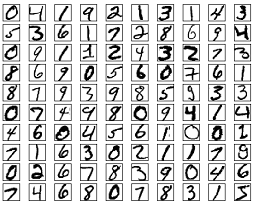

## [Step 01] 라이브러리 로딩

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold

from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

> 랜덤수 생성 시, Seed 고정 ==> 항상 동일한 랜덤 수 생성

In [2]:
SEED = 1122 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!nvidia-smi

Wed Feb  8 15:03:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    49W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## [Step 02] MINIST 데이터셋 로딩

> Google Drive 연결

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!pwd

Mounted at /content/drive
/content


In [5]:
ROOT = '/temp'
train_data = datasets.MNIST(root=ROOT, train=True, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /temp/MNIST/raw/train-images-idx3-ubyte.gz to /temp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /temp/MNIST/raw/train-labels-idx1-ubyte.gz to /temp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /temp/MNIST/raw/t10k-images-idx3-ubyte.gz to /temp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /temp/MNIST/raw



> ### 평균 및 표준편차 계산
- 평균 및 표준편차를 계산하여 Normalization 수행
- Normalization은 Training 데이터에만 적용
- 0-1 데이터 값을 가지기 위해 입력 데이터를 255로 나눔

In [6]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066048920154572
Calculated std: 0.30810779333114624


> ### Normalization 수행 
- Torchvision의 transforms() 함수 사용
- transform() 함수를 사용하여 데이터 Augmentation 수행 
- `RandomRotation(x, fill=(0,))`
    - x: (-x, +x) 범위에서 랜덤하게 이미지 회전
    - fill=(0,): torchvision의 버전에 따른 [버그](https://github.com/pytorch/vision/issues/1759)를 해결하기 위함
- `ToTensor()` - PIL 이미지에서 PyTorch tensor로 변환
- `Normalize` - 평균을 빼고 표준편차로 나눠 정규화

In [7]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])])

> 데이터셋 다운로드 및 셋팅

In [8]:
# 위에서 정의된 transforms를 기반하여 데이터 셋팅
transform = transforms.ToTensor()
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=transform)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=transform)

In [9]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


### Validation 데이터셋
- MINIST Dataset은 Train 및 Test 데이터로 제공
- Training 데이터의 10%를 Validation 데이터로 사용

In [24]:
VALID_RATIO = 0.9

n_train = int(len(train_data) * VALID_RATIO)
n_valid = len(train_data) - n_train

In [25]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train, n_valid])

In [26]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 48600
Number of validation examples: 5400
Number of testing examples: 10000


### Validation 데이터 변형
- Validation 데이터는 Training 데이터로부터 추출
- 따라서, Training 데이터셋에 적용된 Transformation이 적용됨
- Validation 데이터를 Transformation이 적용되지 않은 데이터로 변경
    - Test 데이터셋의 Transformation 형식을 Validation 데이터셋에 적용
    - Validation 데이터는 Training 데이터의 Subset이므로 한 그룹을 변경하면 다른 그룹에도 적용됨
    - deepcopy()함수를 활용하여 validation과 training의 관계를 끊어버림

In [27]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

## [Step 03] 학습 데이터 가시화

In [28]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

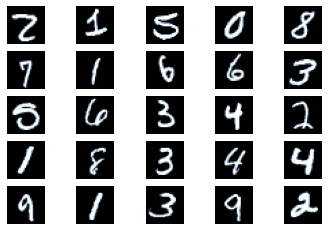

In [29]:
n_images = 25
images = [image for image, label in [train_data[i] for i in range(n_images)]]
plot_images(images)

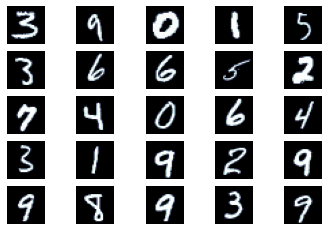

In [30]:
N_IMAGES = 25
images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]
plot_images(images)

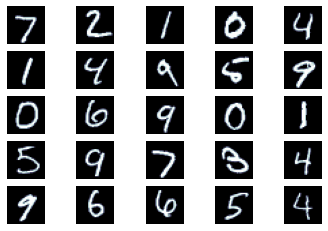

In [32]:
N_IMAGES = 25
images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
plot_images(images)

## [Step 04] 데이터로더 생성

In [33]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

(64, 1, 28, 28)


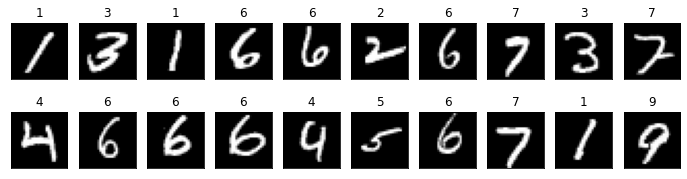

In [37]:
# Obtain one batch of training images
dataiter = iter(train_iterator)

images, labels = next(dataiter)
images = images.numpy()

print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(12, 3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
 
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

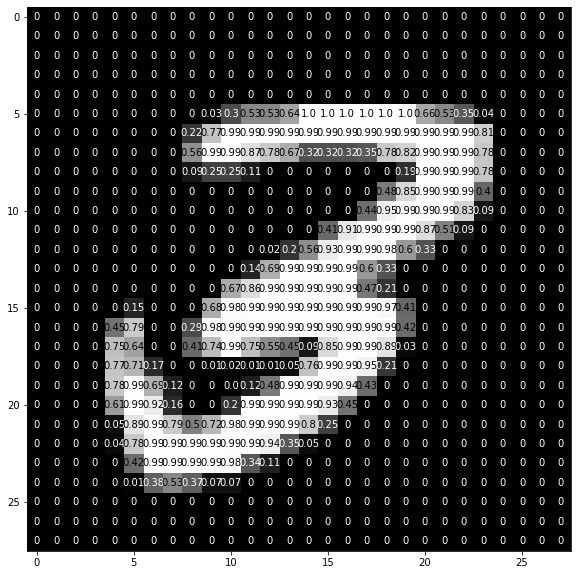

In [38]:
# squeeze를 이용해서 크기가 1인 축을 없애 차원을 축소
img = np.squeeze(images[1])

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

width, height = img.shape

thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        
        # 격자안 색이 thresh 이하일 경우 글자 색은 하얀색
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## [Step 05] 네트워크 모델 정의

<center><img src = "https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1" width="50%"></center>

- 네트워크 입력으로 이미지(28*28*1)를 784 벡터로 변경
- 첫번째 은닉층은 798 입력 그리고 250 출력을 가지는 레이어
- 두번째 은닉층은 250 입력 그리고 100 출력을 가지는 레이어
- 출력층은 10개의 노드를 가짐(0-9 숫자)

In [41]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # x = [batch size, height * width]
        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]
        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        
        # y_pred = [batch size, output dim]

        return y_pred, h_2

In [42]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

> 학습 파라미터(weights and biases) 수 계산
> $$784 \cdot 250 + 250 + 250 \cdot 100 + 100 + 100 \cdot 10 + 10 = 222,360 $$



In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


## [Step 06] 네트워크 모델 학습

In [44]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

### 성능측정 함수
- .eq() 함수를 활용하여 모델의 예측 패션 아이템과 레이블이 일치하는지 확인(일치 1, 아니면 0)
- 이후, .sum()을 사용하여 정답인 것들에 대한 합이 구해짐
- view_as() 함수는 target 텐서를 view_as() 함수 안에 들어가는 인수(pred)의 모양대로 다시 정렬


In [45]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

### 모델 학습 함수 정의

In [46]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### 성능평가 모듈
- put our model into evaluation mode with `model.eval()`
- wrap the iterations inside a `with torch.no_grad()`
- do not zero gradients as we are not calculating any
- do not calculate gradients as we are not updating parameters
- do not take an optimizer step as we are not calculating gradients

In [47]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### 학습 시간 측정 모듈

In [48]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 학습 진행

- 매 학습마다 loss와 accuracy를 계산
- 최고의 validation loss와 accuracy를 보여주는 모델의 파라미터를 저장(state_dict)

In [49]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.318 | Train Acc: 91.09%
	 Val. Loss: 0.164 |  Val. Acc: 95.45%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.126 | Train Acc: 96.18%
	 Val. Loss: 0.116 |  Val. Acc: 96.57%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.081 | Train Acc: 97.51%
	 Val. Loss: 0.101 |  Val. Acc: 97.27%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.057 | Train Acc: 98.18%
	 Val. Loss: 0.092 |  Val. Acc: 97.43%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.044 | Train Acc: 98.56%
	 Val. Loss: 0.101 |  Val. Acc: 97.19%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.033 | Train Acc: 98.91%
	 Val. Loss: 0.096 |  Val. Acc: 97.40%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.026 | Train Acc: 99.19%
	 Val. Loss: 0.102 |  Val. Acc: 97.36%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.022 | Train Acc: 99.25%
	 Val. Loss: 0.101 |  Val. Acc: 97.56%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.018 | Train Acc: 99.40%
	 Val. Loss: 0.105 |  Val. Acc: 97.72%


Training:   0%|          | 0/760 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/85 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 6s
	Train Loss: 0.016 | Train Acc: 99.50%
	 Val. Loss: 0.121 |  Val. Acc: 97.37%


### 최적 모델 불러오기

In [50]:
model.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.082 | Test Acc: 97.40%


## [Step 07] 학습된 모델 검증
- 잘못 예측된 사진에 대한 정보 분석
- 아래 함수는 주어진 데이터로부터 모델 예측을 반환

In [51]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [52]:
images, labels, probs = get_predictions(model, test_iterator, device)

# argmax: tensor로부터 가장 큰 값이 있는 곳의 위치를 반환하는 함수
pred_labels = torch.argmax(probs, 1)

print(probs)
print(pred_labels)
print(labels)

tensor([[1.2314e-08, 1.7184e-07, 1.1696e-05,  ..., 9.9991e-01, 3.7760e-06,
         3.9836e-06],
        [2.7790e-07, 8.4440e-05, 9.9722e-01,  ..., 3.4472e-08, 2.4626e-03,
         2.5000e-12],
        [5.1882e-07, 9.9883e-01, 6.8739e-05,  ..., 7.5960e-04, 2.3735e-04,
         2.4685e-07],
        ...,
        [7.5711e-11, 6.7088e-09, 3.8322e-12,  ..., 1.1414e-05, 2.9577e-07,
         1.0840e-05],
        [1.0066e-07, 5.1871e-10, 4.3914e-11,  ..., 7.0096e-08, 7.9741e-05,
         1.9227e-09],
        [2.6075e-08, 8.3243e-11, 8.5369e-09,  ..., 1.4436e-13, 5.6896e-09,
         5.8152e-12]])
tensor([7, 2, 1,  ..., 4, 5, 6])
tensor([7, 2, 1,  ..., 4, 5, 6])


torch eq() 멤버함수를 활용한 정답을 가진 위치 계산

In [53]:
corrects = torch.eq(labels, pred_labels)
print(corrects)

tensor([True, True, True,  ..., True, True, True])


We can then loop through all of the examples over our model's predictions and store all the examples the model got incorrect into an array.

Then, we sort these incorrect examples by how confident they were, with the most confident being first.

In [54]:
# 잘못 예측된 데이터 추출
incorrect_examples = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

잘못 예측된 자료의 가시화

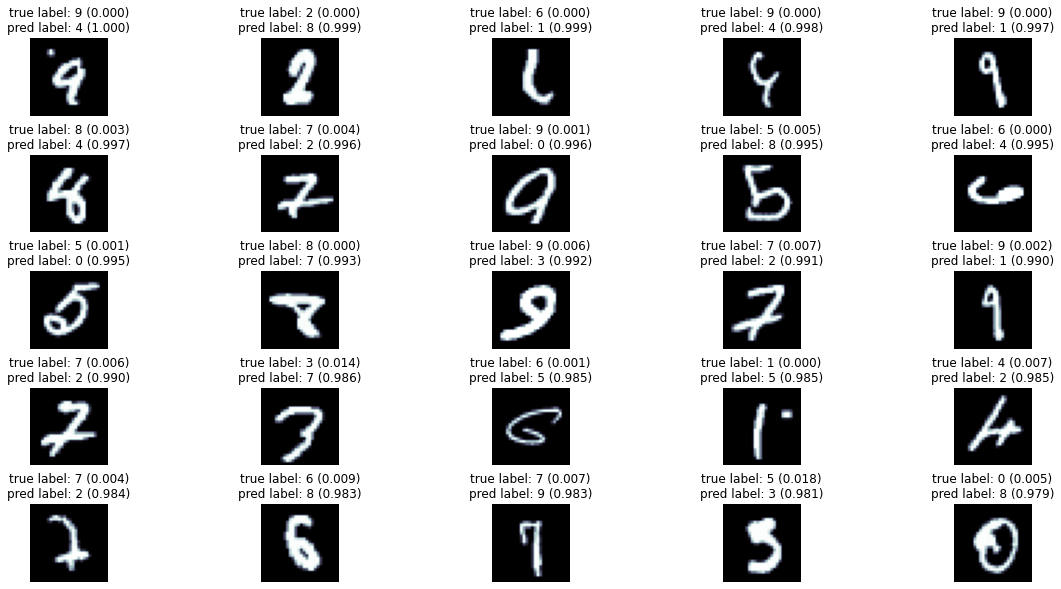

In [55]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)
  
N_IMAGES = 25
plot_most_incorrect(incorrect_examples, N_IMAGES)